### Import libraries

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [4]:
df = pd.read_pickle('FeatureCompunds.pkl')
df

,CID,SMILES,MolecularFormula,MolecularWeight,IUPACName,XLogP,ExactMass,TPSA,Complexity,Charge
0,4,CC(CN)O,C3H9NO,75.11,1-aminopropan-2-ol,-1.0,75.068413911,46.2,22.9,0
1,6,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl,C6H3ClN2O4,202.55,"1-chloro-2,4-dinitrobenzene",2.3,201.9781343,91.6,224.0,0
2,11,C(CCl)Cl,C2H4Cl2,98.96,"1,2-dichloroethane",1.5,97.9690055,0.0,6.0,0
3,13,C1=CC(=C(C=C1Cl)Cl)Cl,C6H3Cl3,181.4,"1,2,4-trichlorobenzene",4.0,179.930033,0.0,94.3,0
4,19,C1=CC(=C(C(=C1)O)O)C(=O)O,C7H6O4,154.12,"2,3-dihydroxybenzoic acid",1.2,154.02660867,77.8,157.0,0
...,...,...,...,...,...,...,...,...,...,...
44996,180258,C1=CC=C(C=C1)C2=CC=C(C=C2)CCNC3=NC=NC4=CC=CC=C43,C22H19N3,325.4,N-[2-(4-phenylphenyl)ethyl]quinazolin-4-amine,6.0,325.157897619,37.8,385.0,0
44997,180259,CCCCOC1=CC=C(C=C1)CCOC2=NC=NC3=CC=CC=C32,C20H22N2O2,322.4,4-[2-(4-butoxyphenyl)ethoxy]quinazoline,5.3,322.168127949,44.2,345.0,0
44998,180497,CCCCN1CCC(CC1)(C2=CC=CC=C2)O.CCCC(=O)O.Cl,C19H32ClNO3,357.9,butanoic acid;1-butyl-4-phenylpiperidin-4-ol;h...,NaN,357.2070716,60.8,265.0,0
44999,180499,CCCC(=O)O.CN1CCC(CC1)(C2=CC=CC=C2)O.Cl,C16H26ClNO3,315.83,butanoic acid;1-methyl-4-phenylpiperidin-4-ol;...,NaN,315.1601214,60.8,228.0,0


In [5]:
df = pd.read_pickle('FeatureCompunds.pkl')
df
fault = []

for smiles, idx in zip(df['SMILES'], df.index.to_list()):
    try: 
        # Convert the SMILES string to an RDKit molecule object
        mol = Chem.MolFromSmiles(smiles)

        # Compute the Morgan fingerprint for the molecule
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    except:
        fault.append(idx)
fault

[10:49:38] WARNING: not removing hydrogen atom without neighbors
[10:49:40] Explicit valence for atom # 1 Cl, 7, is greater than permitted
[10:49:40] Explicit valence for atom # 1 Br, 3, is greater than permitted
[10:49:40] Explicit valence for atom # 1 Br, 5, is greater than permitted
[10:49:40] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[10:49:40] WARNING: not removing hydrogen atom without neighbors
[10:49:40] Explicit valence for atom # 1 Si, 8, is greater than permitted
[10:49:40] Explicit valence for atom # 1 Si, 8, is greater than permitted
[10:49:40] WARNING: not removing hydrogen atom without neighbors
[10:49:40] Explicit valence for atom # 1 Si, 8, is greater than permitted
[10:49:40] Explicit valence for atom # 3 Si, 8, is greater than permitted
[10:49:40] WARNING: not removing hydrogen atom without neighbors
[10:49:40] WARNING: not removing hydrogen atom without neighbors
[10:49:40] Explicit valence for atom # 1 Si, 8, is greater than permitted
[10:49:40

[11710,
 11892,
 11902,
 11926,
 13680,
 13681,
 13685,
 13690,
 13751,
 16833,
 24664,
 29669,
 29723,
 29728]

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load the dataset into a Pandas DataFrame
df = pd.read_pickle('FeatureCompunds.pkl')
df.drop(index=fault, axis=0, inplace=True)
df.dropna(inplace=True)

# Convert the SMILES strings into molecular fingerprints or descriptors
X = np.array([list(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2)) for smiles in df['SMILES']])
y = df.drop(['SMILES', 'CID', 'MolecularFormula', 'IUPACName'], axis=1).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train multiple machine learning models with multi-output regression
models = {
    'RandomForestRegressor': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'LinearRegression': MultiOutputRegressor(LinearRegression()),
#     'SVR': MultiOutputRegressor(SVR()),
    'XGBoost': MultiOutputRegressor(xgb.XGBRegressor()),
    'LightGBM': MultiOutputRegressor(lgb.LGBMRegressor())
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'R2': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

# Evaluate the performance of each algorithm
print(pd.DataFrame.from_dict(results, orient='index'))

# Evaluate the performance of each algorithm for each feature
columns = ['MolecularWeight', 'XLogP', 'ExactMass', 'TPSA', 'Complexity', 'Charge']
for name, model in models.items():
    for i, feature in enumerate(columns):
        r2 = r2_score(y_test[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
        results[f'{name} - {feature}'] = {'R2': r2, 'MSE': mse, 'MAE': mae}
        
        if name == 'RandomForestRegressor':
            RFDF = pd.DataFrame.from_dict(results, orient='index')
        elif name == 'LinearRegression':
            LRDF = pd.DataFrame.from_dict(results, orient='index')
        elif name == 'XGBoost':
            xgbDF = pd.DataFrame.from_dict(results, orient='index')
        elif name == 'LightGBM':
            GBMDF = pd.DataFrame.from_dict(results, orient='index')
        
merged_df = pd.concat([xgbDF, RFDF, LRDF, GBMDF]).reset_index()
merged_df

[12:49:15] WARNING: not removing hydrogen atom without neighbors
[12:50:01] WARNING: not removing hydrogen atom without neighbors


                R2          MSE        MAE
LightGBM  0.798687  2506.038829  24.598702
                                  R2          MSE        MAE
LightGBM                    0.798687  2506.038829  24.598702
LightGBM - MolecularWeight  0.828115  3100.787830  38.122108
LightGBM - XLogP            0.752781     1.185681   0.738959
LightGBM - ExactMass        0.827442  3108.330379  38.033040
LightGBM - TPSA             0.848194   316.564363  11.175260
LightGBM - Complexity       0.850003  8509.362554  59.515318
LightGBM - Charge           0.685587     0.002167   0.007527


(array([0, 1, 2, 3]),
 [Text(0, 0, 'XGBoost - MolecularWeight'),
  Text(1, 0, 'RandomForestRegressor - MolecularWeight'),
  Text(2, 0, 'LinearRegression - MolecularWeight'),
  Text(3, 0, 'LightGBM - MolecularWeight')])

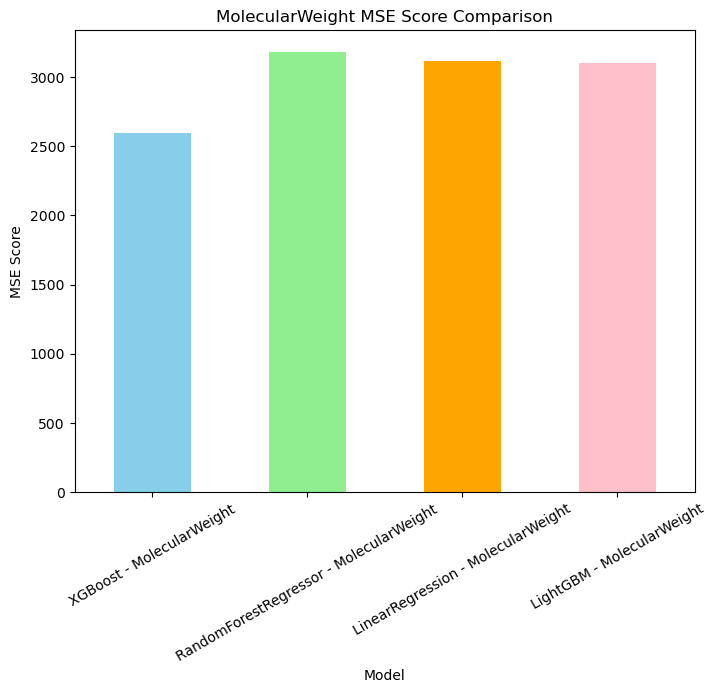

In [70]:
filtered_df = merged_df[merged_df['index'].str.endswith('MolecularWeight')]

fig, ax = plt.subplots(figsize=(8, 6))
filtered_df.set_index('index')['MSE'].plot(kind='bar', color=colors, ax=ax)
plt.title('MolecularWeight MSE Score Comparison')
plt.xlabel('Model')
plt.ylabel('MSE Score')
plt.xticks(rotation=30)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'XGBoost - XLogP'),
  Text(1, 0, 'RandomForestRegressor - XLogP'),
  Text(2, 0, 'LinearRegression - XLogP'),
  Text(3, 0, 'LightGBM - XLogP')])

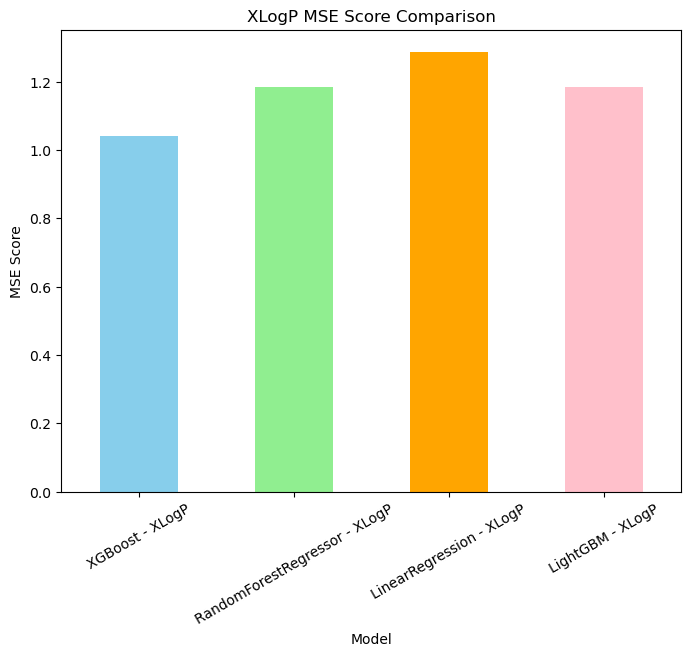

In [69]:
filtered_df = merged_df[merged_df['index'].str.endswith('XLogP')]

fig, ax = plt.subplots(figsize=(8, 6))
filtered_df.set_index('index')['MSE'].plot(kind='bar', color=colors, ax=ax)
plt.title('XLogP MSE Score Comparison')
plt.xlabel('Model')
plt.ylabel('MSE Score')
plt.xticks(rotation=30)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'XGBoost - ExactMass'),
  Text(1, 0, 'RandomForestRegressor - ExactMass'),
  Text(2, 0, 'LinearRegression - ExactMass'),
  Text(3, 0, 'LightGBM - ExactMass')])

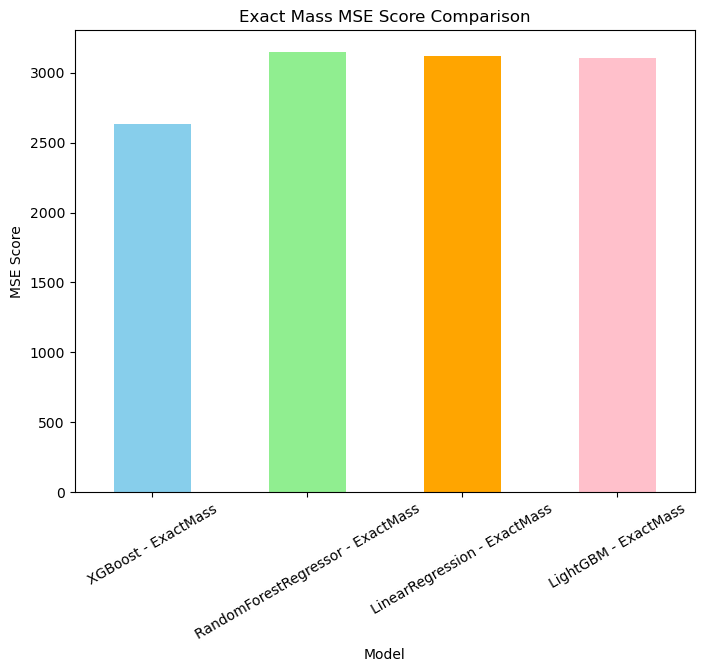

In [68]:
filtered_df = merged_df[merged_df['index'].str.endswith('ExactMass')]

fig, ax = plt.subplots(figsize=(8, 6))
filtered_df.set_index('index')['MSE'].plot(kind='bar', color=colors, ax=ax)
plt.title('Exact Mass MSE Score Comparison')
plt.xlabel('Model')
plt.ylabel('MSE Score')
plt.xticks(rotation=30)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'XGBoost - TPSA'),
  Text(1, 0, 'RandomForestRegressor - TPSA'),
  Text(2, 0, 'LinearRegression - TPSA'),
  Text(3, 0, 'LightGBM - TPSA')])

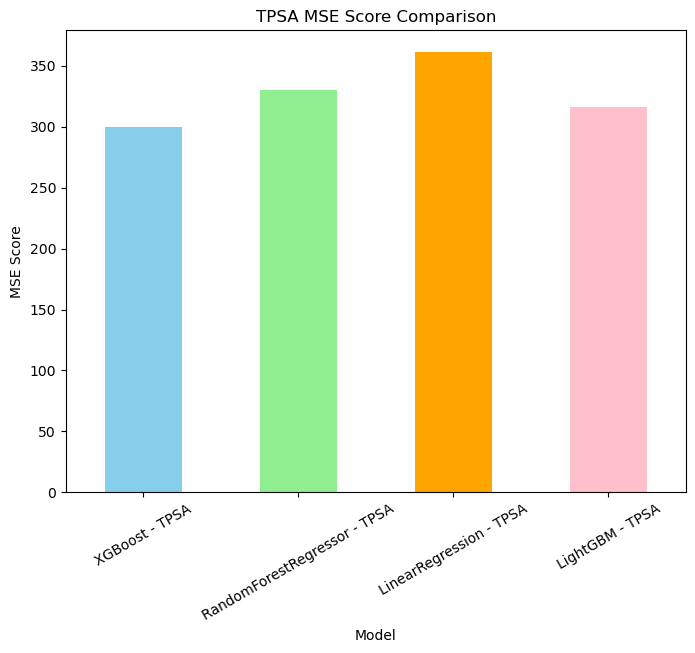

In [67]:
filtered_df = merged_df[merged_df['index'].str.endswith('TPSA')]

fig, ax = plt.subplots(figsize=(8, 6))
filtered_df.set_index('index')['MSE'].plot(kind='bar', color=colors, ax=ax)
plt.title('TPSA MSE Score Comparison')
plt.xlabel('Model')
plt.ylabel('MSE Score')
plt.xticks(rotation=30)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'XGBoost - Complexity'),
  Text(1, 0, 'RandomForestRegressor - Complexity'),
  Text(2, 0, 'LinearRegression - Complexity'),
  Text(3, 0, 'LightGBM - Complexity')])

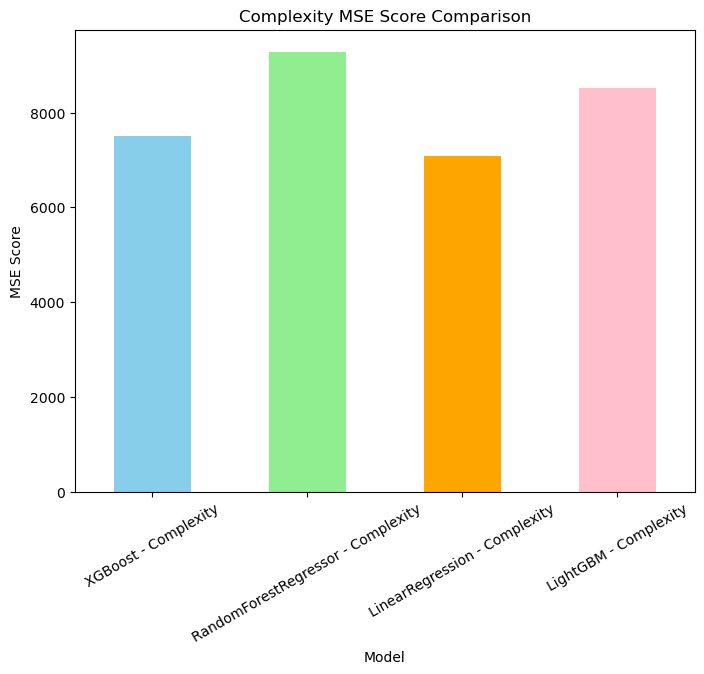

In [66]:
filtered_df = merged_df[merged_df['index'].str.endswith('Complexity')]

fig, ax = plt.subplots(figsize=(8, 6))
filtered_df.set_index('index')['MSE'].plot(kind='bar', color=colors, ax=ax)
plt.title('Complexity MSE Score Comparison')
plt.xlabel('Model')
plt.ylabel('MSE Score')
plt.xticks(rotation=30)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'XGBoost - Charge'),
  Text(1, 0, 'RandomForestRegressor - Charge'),
  Text(2, 0, 'LinearRegression - Charge'),
  Text(3, 0, 'LightGBM - Charge')])

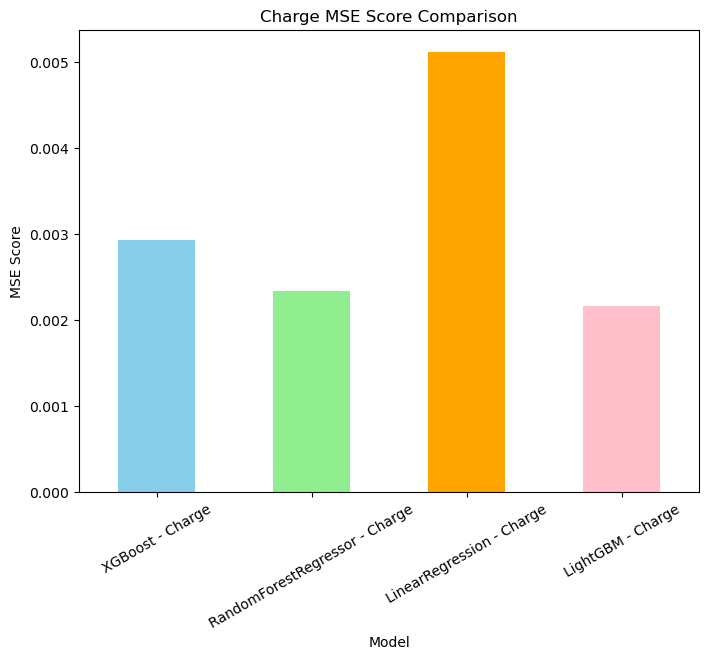

In [65]:
filtered_df = merged_df[merged_df['index'].str.endswith('Charge')]

fig, ax = plt.subplots(figsize=(8, 6))
filtered_df.set_index('index')['MSE'].plot(kind='bar', color=colors, ax=ax)
plt.title('Charge MSE Score Comparison')
plt.xlabel('Model')
plt.ylabel('MSE Score')
plt.xticks(rotation=30)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'XGBoost'),
  Text(1, 0, 'RandomForestRegressor'),
  Text(2, 0, 'LinearRegression'),
  Text(3, 0, 'LightGBM')])

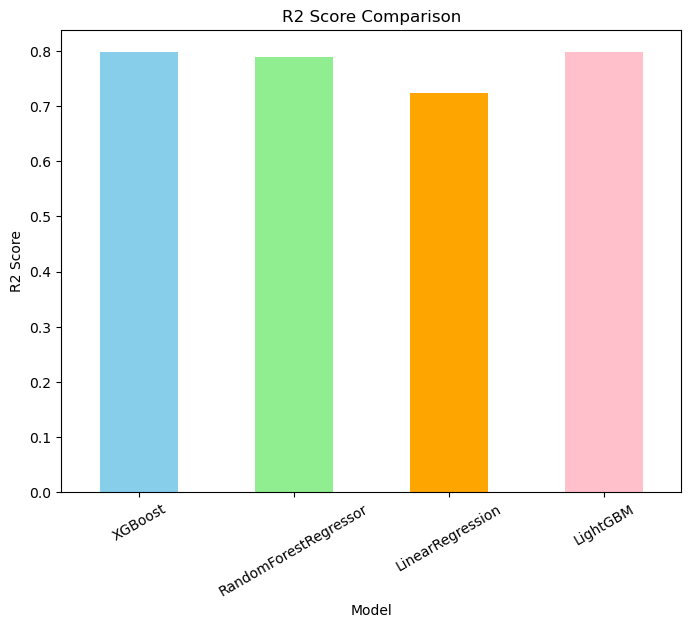

In [56]:
import matplotlib.pyplot as plt
colors = ['skyblue', 'lightgreen', 'orange', 'pink']
filtered_df = merged_df[merged_df['index'].isin(['XGBoost', 'RandomForestRegressor', 'LinearRegression', 'LightGBM'])]

# Plot the filtered DataFrame with colors
fig, ax = plt.subplots(figsize=(8, 6))

filtered_df.set_index('index')['R2'].plot(kind='bar', color=colors, ax=ax)
plt.title('R2 Score Comparison')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.xticks(rotation=30)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'XGBoost'),
  Text(1, 0, 'RandomForestRegressor'),
  Text(2, 0, 'LinearRegression'),
  Text(3, 0, 'LightGBM')])

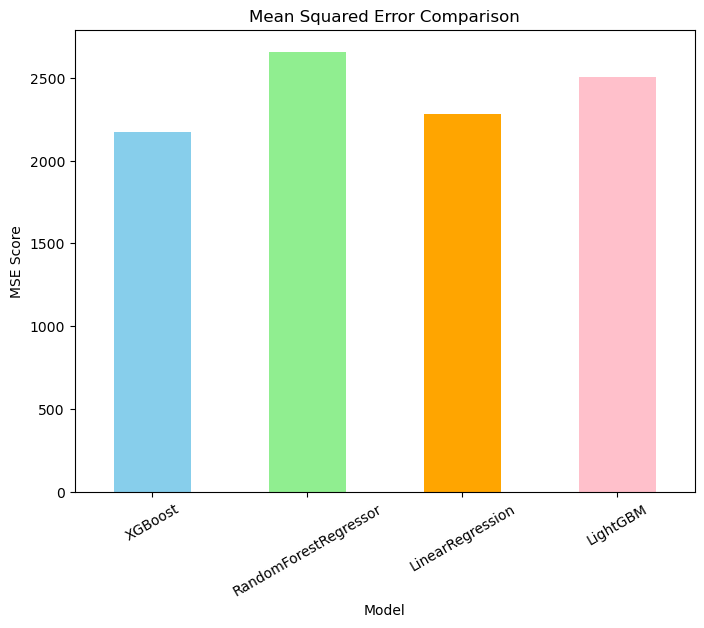

In [55]:
import matplotlib.pyplot as plt
colors = ['skyblue', 'lightgreen', 'orange', 'pink']

filtered_df = merged_df[merged_df['index'].isin(['XGBoost', 'RandomForestRegressor', 'LinearRegression', 'LightGBM'])]

# Plot the filtered DataFrame with colors
fig, ax = plt.subplots(figsize=(8, 6))

filtered_df.set_index('index')['MSE'].plot(kind='bar', color=colors, ax=ax)
plt.title('Mean Squared Error Comparison')
plt.xlabel('Model')
plt.ylabel('MSE Score')
plt.xticks(rotation=30)